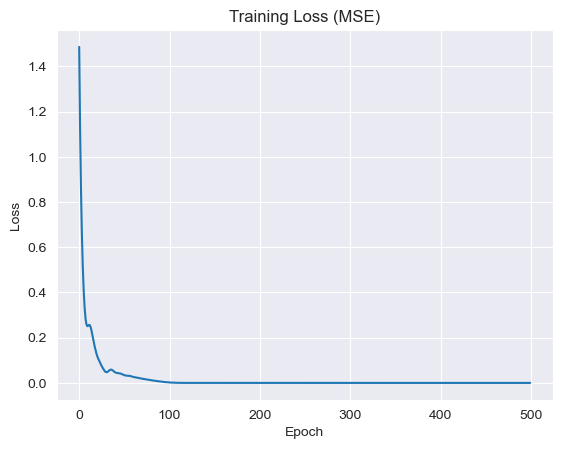

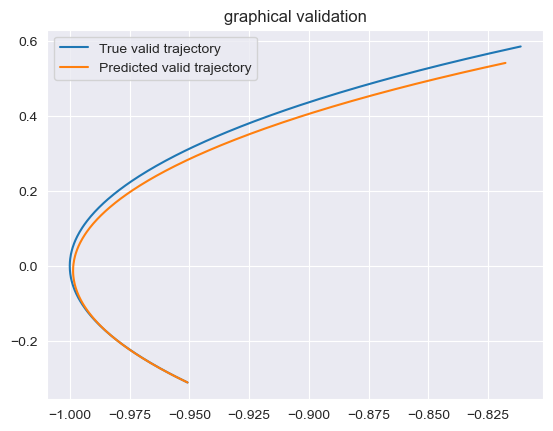

모델 0 valid r^2 : 0.9999044194429916


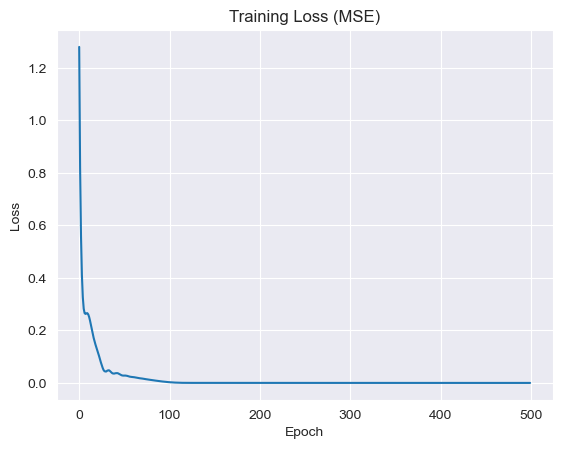

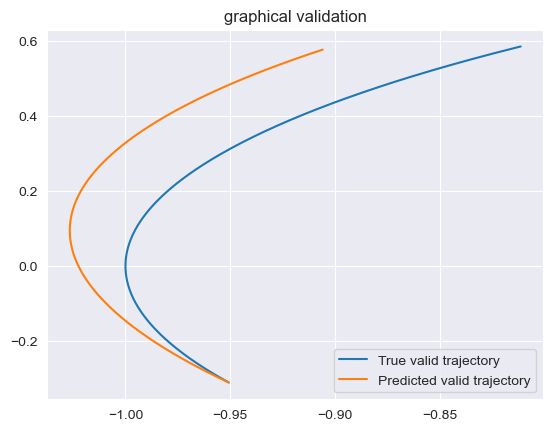

모델 1 valid r^2 : 0.9986358323294862


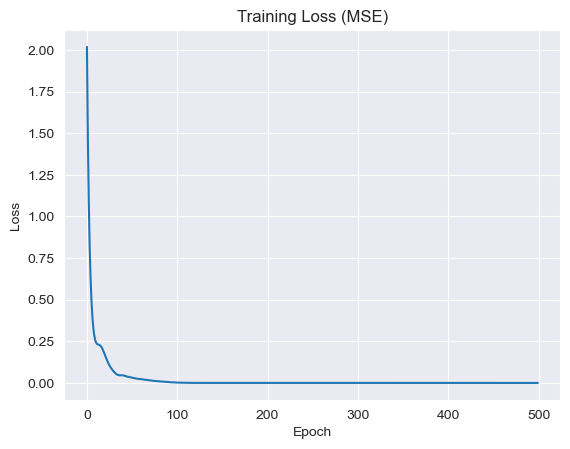

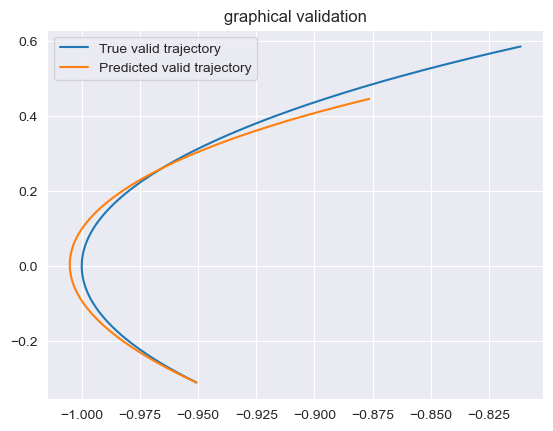

모델 2 valid r^2 : 0.9980810050161075


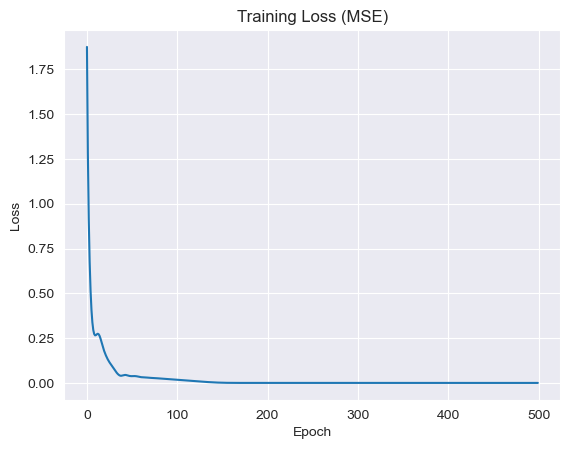

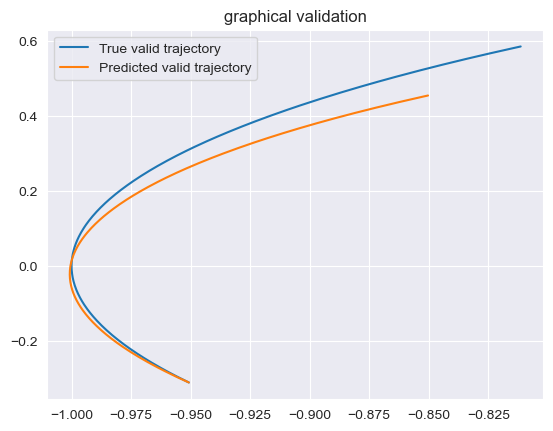

모델 3 valid r^2 : 0.9988414343214226


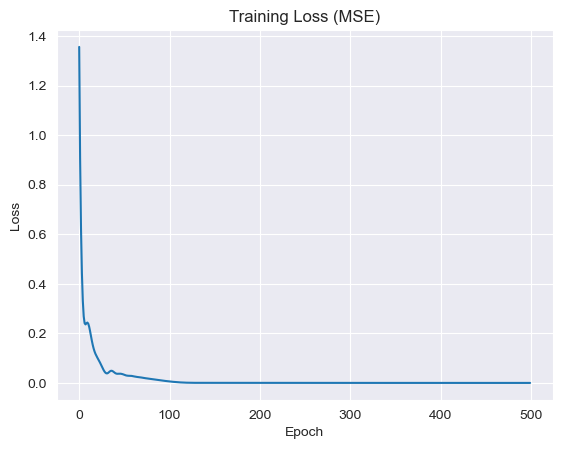

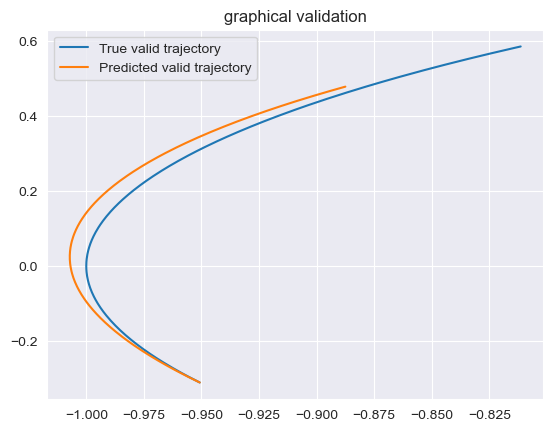

모델 4 valid r^2 : 0.9983154723858754
가장 우수한 모델: 0, valid r^2 :0.9999044194429916


In [21]:

from scipy.stats import linregress
from torchdiffeq import odeint
from sklearn.metrics import mean_absolute_error
from prettytable import PrettyTable
from scipy.optimize import minimize
import numpy as np
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import copy
from pyDOE import lhs
import os

save_path = 'results'

# 디렉토리가 존재하지 않으면 생성
if not os.path.exists(save_path):
    os.makedirs(save_path)
    



def train_ode_models(n_samples, hidden_dim, learning_rate, epochs_list):
    # Latin Hypercube Design (LHD) 샘플 생성
    lhd_samples = lhs(2, samples=n_samples)
    t_lhd = torch.tensor(np.sort(lhd_samples[:, 0]) * 2 * np.pi, dtype=torch.float32)
    x_lhd = torch.cat((torch.sin(t_lhd).reshape(-1, 1), torch.cos(t_lhd).reshape(-1, 1)), dim=1)

    # 데이터 분할
    train_size = int(0.7 * len(x_lhd))
    val_size = int(0.15 * len(x_lhd))
    test_size = len(x_lhd) - train_size - val_size
    
    x_train = x_lhd[:train_size]
    t_train = t_lhd[:train_size]
    
    x_val = x_lhd[train_size:train_size + val_size]
    t_val = t_lhd[train_size:train_size + val_size]
    
    # 테스트 세트
    x_test = x_lhd[train_size + val_size:]
    t_test = t_lhd[train_size + val_size:]

    # 결과 저장
    best_func = None
    r_squared_val = []
    r_squared_check = 0
    r_squared_results = pd.DataFrame(columns=['Epochs', 'R_Squared'])

    # 모델 정의 및 훈련
    for idx, epochs in enumerate(epochs_list):
        # Neural network 및 ODE 정의
        class ODEF(nn.Module):
            def forward(self, t, x):
                return self.net(x)

            def __init__(self, in_dim, hidden_dim, out_dim):
                super(ODEF, self).__init__()
                self.net = nn.Sequential(
                    nn.Linear(in_dim, hidden_dim),
                    nn.ELU(),
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.ELU(),
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.ELU(),
                    nn.Linear(hidden_dim, out_dim)
                )

        func = ODEF(2, hidden_dim, 2)
        optimizer = torch.optim.Adam(func.parameters(), lr=learning_rate)

        # 훈련
        losses = []
        for epoch in range(epochs):
            optimizer.zero_grad()
            x_pred_train = odeint(func, x_train[0], t_train).squeeze()
            loss = ((x_pred_train - x_train) ** 2).mean()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
       
        x_pred_val = odeint(func, x_val[0], t_val).squeeze()
        # 손실 그래프 저장
        plt.plot(losses)
        plt.title('Training Loss (MSE)')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig(f"{save_path}/loss_plot_{idx}.png")
        plt.close()

        # 검증
        x_pred_val = odeint(func, x_val[0], t_val).squeeze()
        slope, intercept, r_value, _, _ = linregress(x_val.flatten().detach().numpy(), x_pred_val.flatten().detach().numpy())
        r_squared_val.append(r_value**2)
        
        # 검증 그래프 저장
        plt.plot(x_val[:, 0].detach().numpy(), x_val[:, 1].detach().numpy(), label='True valid trajectory')
        plt.plot(x_pred_val[:, 0].detach().numpy(), x_pred_val[:, 1].detach().numpy(), label='Predicted valid trajectory')
        plt.legend()
        plt.title('Graphical Validation')
        plt.savefig(f"{save_path}/validation_plot_{idx}.png")
        plt.close()

        # 모델 선택
        if r_squared_check < r_squared_val[idx]:
            r_squared_check = r_squared_val[idx]
            best_func = copy.deepcopy(func)

        # R_Squared 값 저장
        r_squared_results.loc[idx] = [epochs, r_squared_val[idx]]

    # CSV로 저장
    r_squared_results.to_csv(f"{save_path}/r_squared_results.csv", index=False)

    max_r_squared_model = r_squared_val.index(max(r_squared_val))
    return best_func, max_r_squared_model, max(r_squared_val)
  

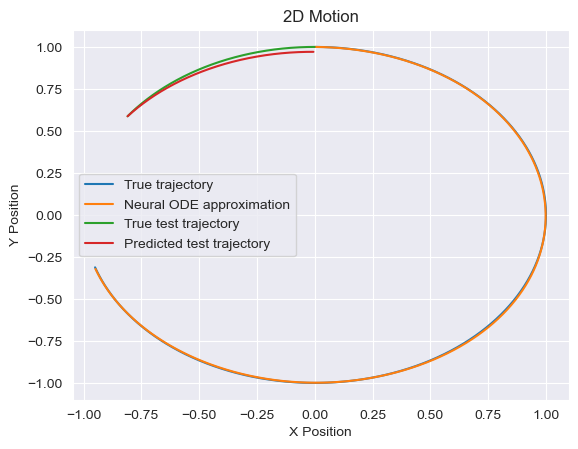

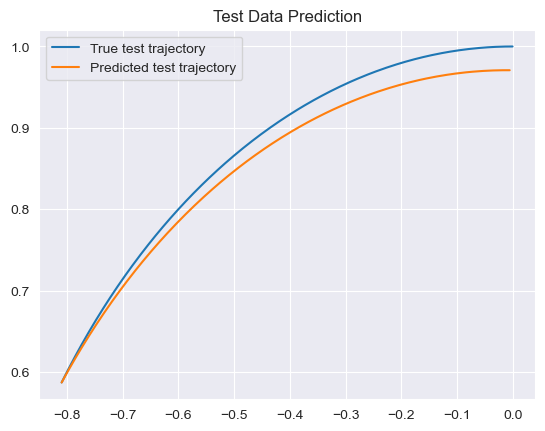

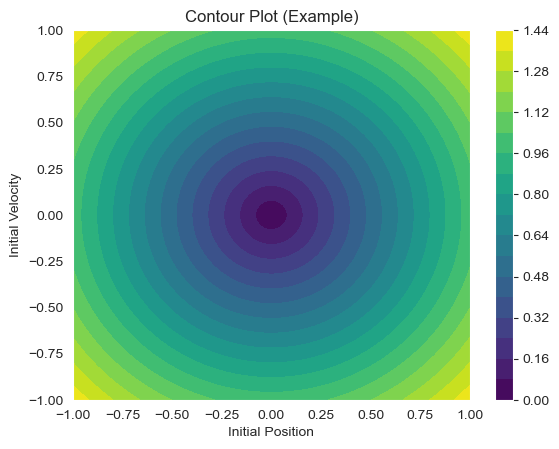

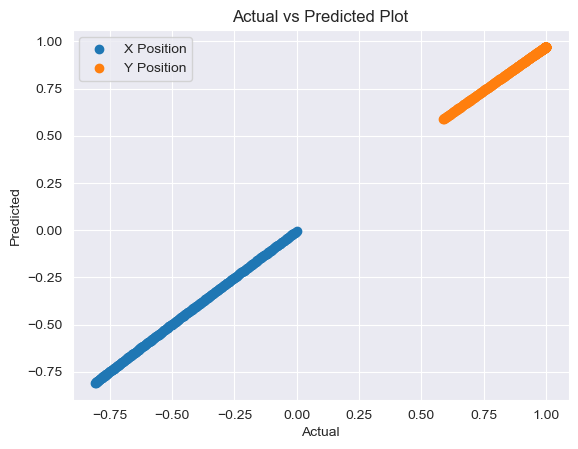

In [22]:
# Plotting the training loss
#plt.plot(losses)
#plt.title('Training Loss (MSE)')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.show()

# Plotting the true trajectory and the Neural ODE approximation
plt.plot(x_train[:, 0].detach().numpy(), x_train[:, 1].detach().numpy(), label='True trajectory')
x_pred = odeint(func, x_train[0], t_train)
plt.plot(x_pred[:, 0].detach().numpy(), x_pred[:, 1].detach().numpy(), label='Neural ODE approximation')
x_pred_test = odeint(func, x_test[0], t_test).squeeze()
plt.plot(x_test[:, 0].detach().numpy(), x_test[:, 1].detach().numpy(), label='True test trajectory')
plt.plot(x_pred_test[:, 0].detach().numpy(), x_pred_test[:, 1].detach().numpy(), label='Predicted test trajectory')
plt.legend()
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('2D Motion')
plt.show()

# Testing the model
x_pred_test = odeint(func, x_test[0], t_test).squeeze()
plt.plot(x_test[:, 0].detach().numpy(), x_test[:, 1].detach().numpy(), label='True test trajectory')
plt.plot(x_pred_test[:, 0].detach().numpy(), x_pred_test[:, 1].detach().numpy(), label='Predicted test trajectory')
plt.legend()
plt.title('Test Data Prediction')
plt.show()


# Testing the model
x_pred_test = odeint(func, x_test[0], t_lhd[train_size + val_size:]).squeeze()

# Graphical Validation
plt.scatter(x_test[:, 0].detach().numpy(), x_pred_test[:, 0].detach().numpy(), label='X Position')
plt.scatter(x_test[:, 1].detach().numpy(), x_pred_test[:, 1].detach().numpy(), label='Y Position')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.title('Actual vs Predicted Plot')
plt.show()


# Numerical Validation
slope, intercept, r_value, _, _ = linregress(x_test.flatten().detach().numpy(), x_pred_test.flatten().detach().numpy())

r_squared = r_value**2
mean_abs_rel_residual = mean_absolute_error(x_test.detach().numpy(), x_pred_test.detach().numpy()) / (x_test.abs().mean())
# Calculate max absolute relative residual for multioutput
max_abs_rel_residual = max(np.max(np.abs(x_test.detach().numpy() - x_pred_test.detach().numpy()), axis=0) / x_test.abs().max())



# Summarize the results
table = PrettyTable()
table.field_names = ["Metric", "Value"]
table.add_row(["Squared correlation coefficient (r^2)", r_squared])
table.add_row(["Mean absolute relative residual", mean_abs_rel_residual])
table.add_row(["Maximum of absolute relative residuals", max_abs_rel_residual])

print(table)




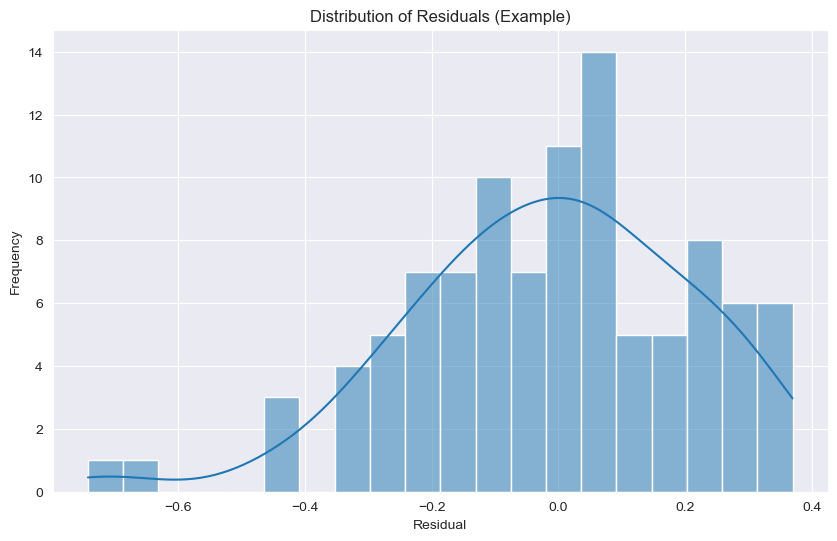

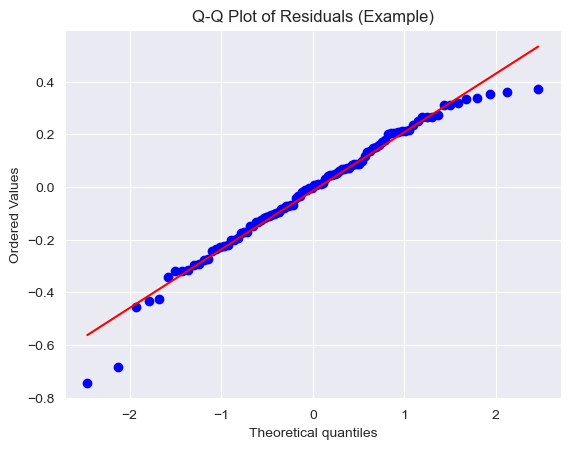

Normality test p-value (Example): 0.030896833018160836


In [24]:
from scipy.stats import probplot, normaltest
import seaborn as sns

# Generating example data for demonstration
np.random.seed(42)
x_values = np.linspace(0, 2 * np.pi, 100)
y_actual = np.sin(x_values) + 0.1 * np.random.normal(size=x_values.shape)
y_predicted = np.sin(x_values) + 0.2 * np.random.normal(size=x_values.shape)

# Calculating residuals for the example data
residuals_example = y_actual - y_predicted

# Plotting residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals_example, kde=True, bins=20)
plt.title('Distribution of Residuals (Example)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot of residuals
probplot(residuals_example, plot=plt)
plt.title('Q-Q Plot of Residuals (Example)')
plt.show()

# Normality test
k2, p_value_example = normaltest(residuals_example)
print("Normality test p-value (Example):", p_value_example)

from scipy.interpolate import griddata

# Create a meshgrid for the contour plot
num_points = 100
X, Y = np.meshgrid(np.linspace(-1, 0, num_points), np.linspace(0.25, 1, num_points))

# Create points and values for interpolation
points = x_test.detach().numpy()
values_true = np.sqrt(points[:, 0]**2 + points[:, 1]**2)
values_pred = np.sqrt(x_pred_test[:, 0].detach().numpy()**2 + x_pred_test[:, 1].detach().numpy()**2)

# Interpolate the values for the contour plot
Z_true = griddata(points, values_true, (X, Y), method='cubic')
Z_pred = griddata(points, values_pred, (X, Y), method='cubic')

# Plot the true contour
plt.contour(X, Y, Z_true, levels=20, colors='r', linestyles='dashed', label='True motion')

# Plot the predicted contour
plt.contour(X, Y, Z_pred, levels=20, colors='b', linestyles='solid', label='Predicted motion')

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Contour Plot Comparison: True vs Predicted Motion')
plt.legend()
plt.show()


print("X range in training:", x_train[:, 0].min().item(), "to", x_train[:, 0].max().item())
print("Y range in training:", x_train[:, 1].min().item(), "to", x_train[:, 1].max().item())

print("X range in prediction:", x_pred_test[:, 0].min().item(), "to", x_pred_test[:, 0].max().item())
print("Y range in prediction:", x_pred_test[:, 1].min().item(), "to", x_pred_test[:, 1].max().item())


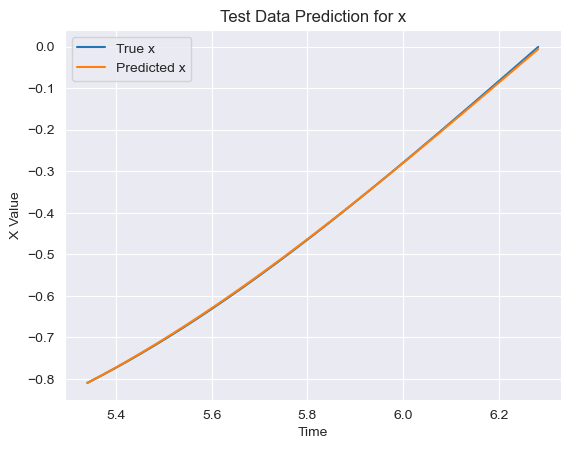

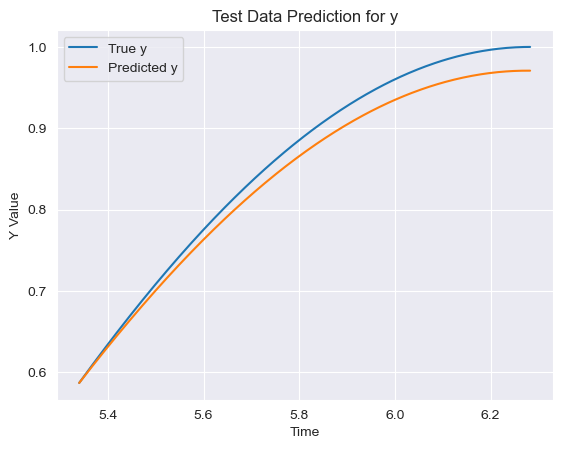

In [27]:

x_pred_test = odeint(func, x_test[0], t_test).detach().numpy().squeeze()

plt.plot(t_test, x_test[:, 0], label="True x")
plt.plot(t_test, x_pred_test[:, 0], label="Predicted x")
plt.legend()
plt.xlabel("Time")
plt.ylabel("X Value")
plt.title("Test Data Prediction for x")
plt.show()

plt.plot(t_test, x_test[:, 1], label="True y")
plt.plot(t_test, x_pred_test[:, 1], label="Predicted y")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Y Value")
plt.title("Test Data Prediction for y")
plt.show()



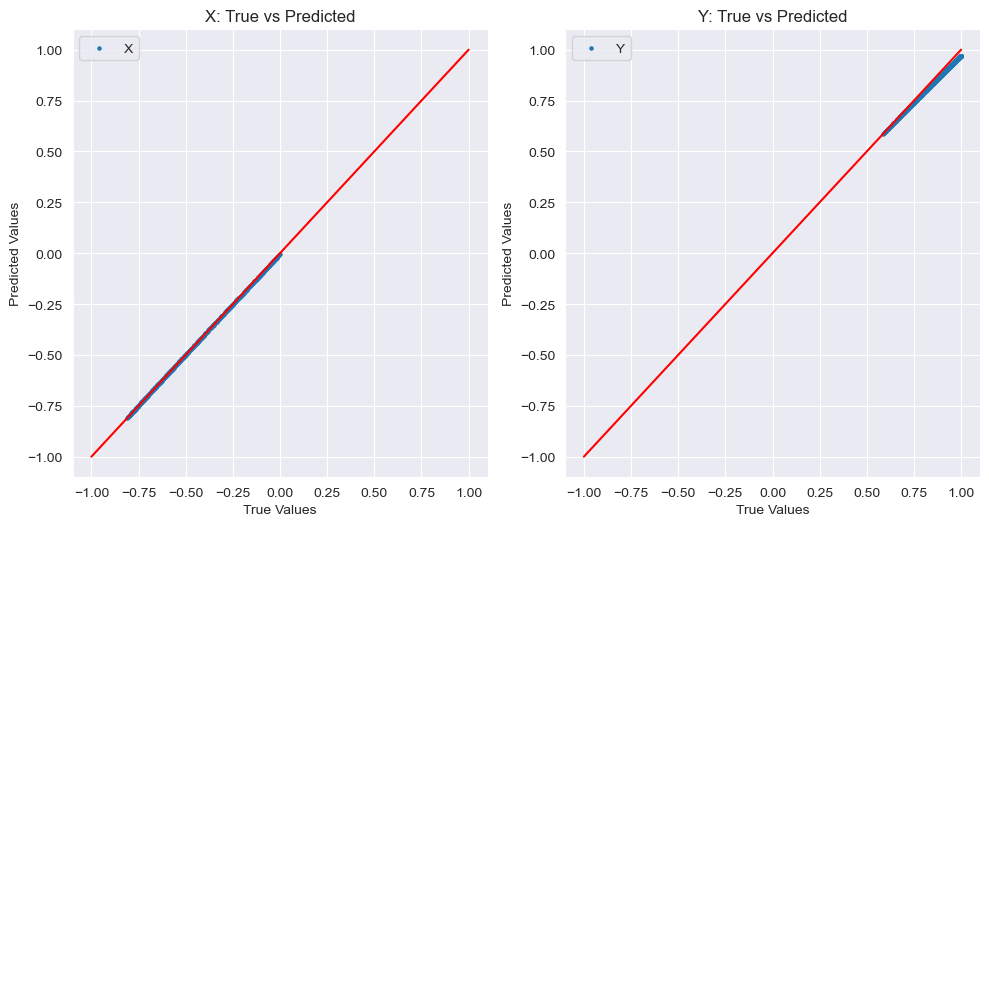

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# 첫 번째 행, 첫 번째 열
axs[0, 0].scatter(x_test[:, 0], x_pred_test[:, 0], label="X", s=5) # s는 마커 크기
axs[0, 0].plot([-1, 1], [-1, 1], color="red") 
axs[0, 0].set_xlabel("True Values")
axs[0, 0].set_ylabel("Predicted Values")
axs[0, 0].legend()
axs[0, 0].set_title("X: True vs Predicted")

# 첫 번째 행, 두 번째 열
axs[0, 1].scatter(x_test[:, 1], x_pred_test[:, 1], label="Y", s=5)
axs[0, 1].plot([-1, 1], [-1, 1], color="red") 
axs[0, 1].set_xlabel("True Values")
axs[0, 1].set_ylabel("Predicted Values")
axs[0, 1].legend()
axs[0, 1].set_title("Y: True vs Predicted")

# 두 번째 행에 다른 그래프나 정보를 표시하거나 빈 공간으로 남겨둘 수 있습니다.
axs[1, 0].axis('off')
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()



In [ ]:
n_samples = 2048
hidden_dim = 32
learning_rate = 0.003
epochs_list = [100, 200, 500]

best_func, max_r_squared_model, max_r_squared = train_ode_models(n_samples, hidden_dim, learning_rate, epochs_list, save_path)
